# Introduction
In this notebook we will test the implementation of the AlexNet class provided in the `alexnet.py` file. This is part of [this](https://kratzert.github.io/2017/02/24/finetuning-alexnet-with-tensorflow.html) blog article on how to finetune AlexNet with TensorFlow 1.0.

To run this notebook you have to download the `bvlc_alexnet.npy` file from [here](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/), which stores the pretrained weigts of AlexNet.

The idea to validate the implementation is to create an AlexNet graph with the provided script and load all pretrained weights into the variables (so no finetuneing!), to see if everything is wired up correctly.

In [1]:
#some basic imports and setups
import os
import cv2
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt


#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

%matplotlib inline



Instructions for updating:
non-resource variables are not supported in the long term


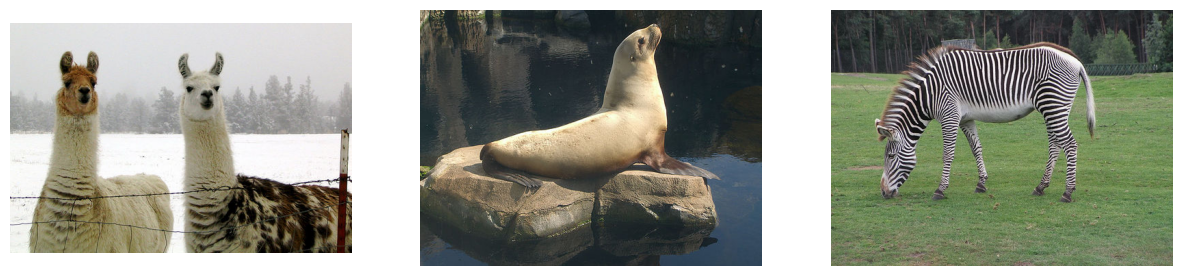

In [2]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

First we will create placeholder for the dropout rate and the inputs and create an AlexNet object. Then we will link the activations from the last layer to the variable `score` and define an op to calculate the softmax values.

In [3]:
from alexnet import AlexNet
from caffe_classes import class_names

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 1000, [])

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now we will start a TensorFlow session and load pretrained weights into the layer weights. Then we will loop over all images and calculate the class probability for each image and plot the image again, together with the predicted class and the corresponding class probability.

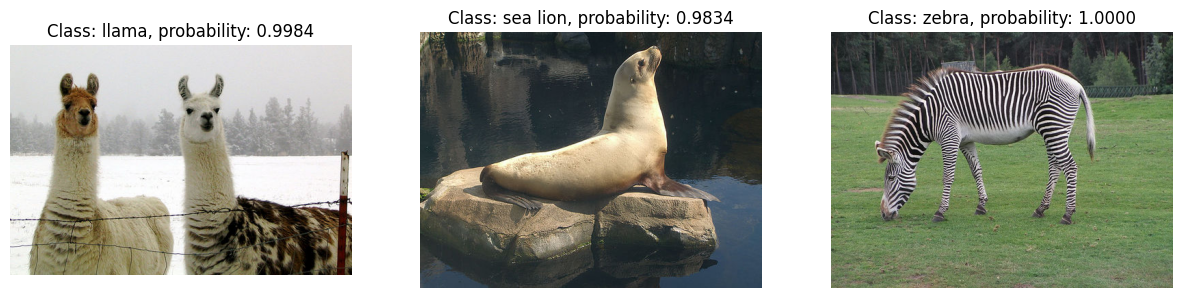

In [4]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')